In [1]:
import numpy as np
import pandas as pd
import shap
import requests
from lime.lime_tabular import LimeTabularExplainer
from folktables import ACSDataSource, ACSPublicCoverage, ACSIncome, BasicProblem, adult_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from interpret import show
from interpret.glassbox import LogisticRegression

/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_1021/130885992.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Test 1: on the influence of individual categorical variables on the results

### gender

In [3]:
resume_scored_evaluated = pd.read_csv("/Users/ziaozhang/Desktop/CSCI1951Z_FinalProject/1_4000_resumes_evaluated.csv")
print(resume_scored_evaluated.columns.tolist())

['Unnamed: 0', 'Applicant ID', 'School Name', 'GPA', 'Degree', 'Location', 'Gender', 'Veteran status', 'Work authorization', 'Disability', 'Ethnicity', 'Role 1', 'Start 1', 'End 1', 'Role 2', 'Start 2', 'End 2', 'Role 3', 'Start 3', 'End 3', 'Resume score', 'prediction']


In [7]:
print(resume_scored_evaluated['prediction'])
print(resume_scored_evaluated['GPA'])

0       0
1       1
2       0
3       0
4       0
       ..
3995    0
3996    0
3997    1
3998    0
3999    0
Name: prediction, Length: 4000, dtype: int64
0       2.09
1       3.24
2       3.12
3       2.69
4       2.63
        ... 
3995    3.29
3996    3.53
3997    3.17
3998    2.53
3999    2.06
Name: GPA, Length: 4000, dtype: float64


In [5]:
print(resume_scored_evaluated['Gender'])

0       NaN
1         M
2         F
3       NaN
4         F
       ... 
3995    NaN
3996      M
3997      F
3998    NaN
3999    NaN
Name: Gender, Length: 4000, dtype: object


EDA Part with more features and different plots:

/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_1021/4033881047.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='GPA', y='Prediction', data=df,palette= ['skyblue', 'salmon'],orient='h')


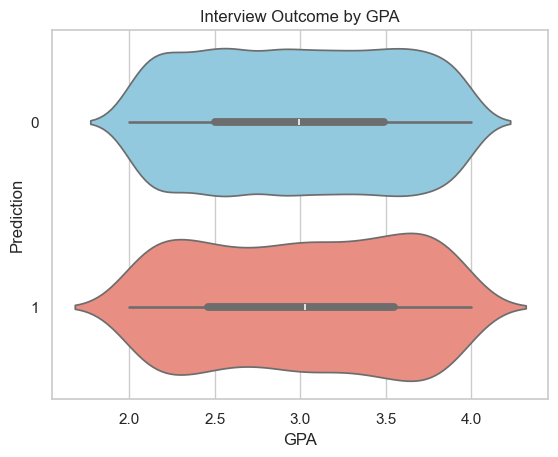

In [24]:
data = {'GPA': resume_scored_evaluated['GPA'], 'Prediction': resume_scored_evaluated['prediction']}
df = pd.DataFrame(data)

# Create a violin plot
sns.violinplot(x='GPA', y='Prediction', data=df,palette= ['skyblue', 'salmon'],orient='h')
plt.xlabel('GPA')
plt.ylabel('Prediction')
plt.title('Interview Outcome by GPA')
plt.show()

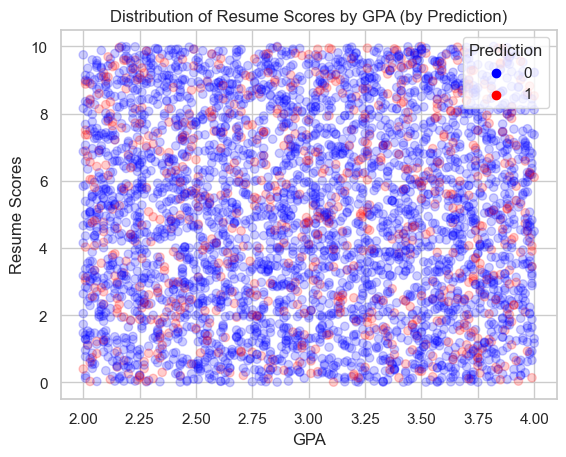

In [80]:
prediction_colors = {0: 'blue', 1: 'red'}
plt.scatter(resume_scored_evaluated['GPA'],resume_scored_evaluated['Resume score'] ,c=resume_scored_evaluated['prediction'].map(prediction_colors),cmap='coolwarm', alpha=0.2)  # Alpha controls transparency
plt.xlabel('GPA')
plt.ylabel('Resume Scores')
plt.title('Distribution of Resume Scores by GPA (by Prediction)')
plt.clim(-0.5, 1.5)  # Set the color limits
# Customize colorbar ticks and labels
legend_colors = [plt.scatter([], [], color=prediction_colors[0]), plt.scatter([], [], color=prediction_colors[1])]
plt.legend(legend_colors, ['0', '1'], title='Prediction')

plt.show()

In [26]:
print(resume_scored_evaluated['Degree'])


0         Masters
1             Phd
2       Bachelors
3             Phd
4       Bachelors
          ...    
3995      Masters
3996          Phd
3997          Phd
3998    Bachelors
3999          Phd
Name: Degree, Length: 4000, dtype: object


<class 'pandas.core.series.Series'>
Degree
Bachelors    1383
Phd          1333
Masters      1284
Name: count, dtype: int64


/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_1021/1149833507.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Degree', y='Resume Score', data=df,palette=colors)
/Users/ziaozhang/anaconda3/envs/csci1470/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ziaozhang/anaconda3/envs/csci1470/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ziaozhang/anaconda3/envs/csci1470/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want 

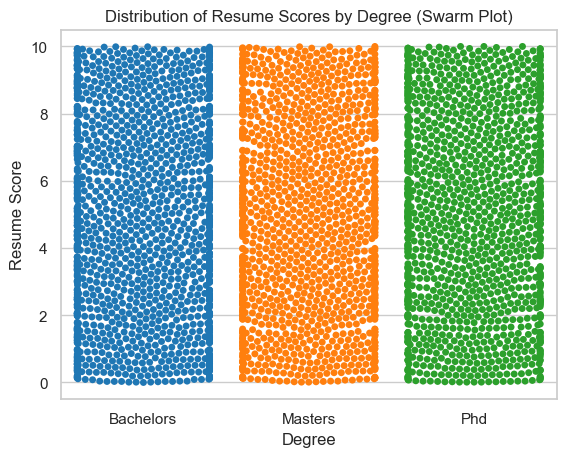

In [50]:
degrees = ['Masters','Phd','Bachelors']
resume_scores_bachelor = resume_scored_evaluated.loc[resume_scored_evaluated['Degree'] == 'Bachelors', 'Resume score']
resume_scores_master = resume_scored_evaluated.loc[resume_scored_evaluated['Degree'] == 'Masters', 'Resume score']
resume_scores_phd = resume_scored_evaluated.loc[resume_scored_evaluated['Degree'] == 'Phd', 'Resume score']

df = pd.DataFrame({
    'Degree': ['Bachelors'] * len(resume_scores_bachelor) + ['Masters'] * len(resume_scores_master) + ['Phd'] * len(resume_scores_phd),
    'Resume Score': list(resume_scores_bachelor) + list(resume_scores_master) + list(resume_scores_phd),
})
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
sns.swarmplot(x='Degree', y='Resume Score', data=df,palette=colors)
plt.xlabel('Degree')
plt.ylabel('Resume Score')
plt.title('Distribution of Resume Scores by Degree (Swarm Plot)')
plt.show()


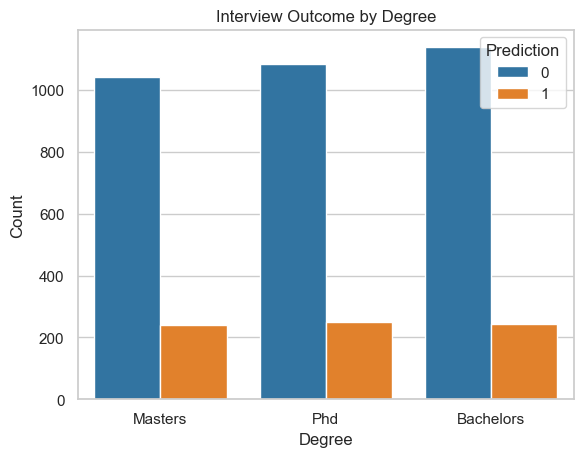

In [83]:
degrees = ['Masters','Phd','Bachelors']
predictions_eda=resume_scored_evaluated['prediction']
predictions_by_degree = {
    degree: predictions_eda[resume_scored_evaluated['Degree'] == degree]
    for degree in degrees
}

# Create a DataFrame with correct length
data = []
for degree in degrees:
    data.extend([degree] * len(predictions_by_degree[degree]))

df = pd.DataFrame({
    'Degree': data,
    'Prediction': [prediction for predictions in predictions_by_degree.values() for prediction in predictions]
})
colors = ["#1f77b4", "#ff7f0e"]
sns.countplot(x='Degree', hue='Prediction', data=df,palette=colors)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Interview Outcome by Degree')
plt.legend(title='Prediction')
plt.show()

/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_1021/4036972065.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gender', y='Resume Score', data=df, inner='quartile', cut=0,palette=colors)


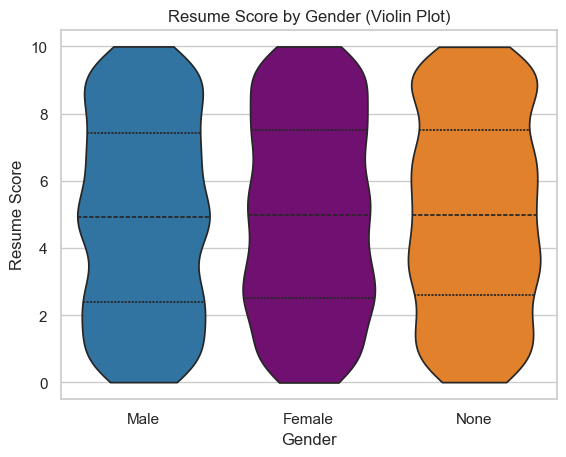

In [70]:
genders =['M','F',None]
resume_male = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'] == 'M', 'Resume score']
resume_female = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'] == 'F', 'Resume score']
resume_n = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'].isna(), 'Resume score']  # Filter NaN values

# Create a DataFrame
df = pd.DataFrame({
    'Gender': ['Male'] * len(resume_male) + ['Female'] * len(resume_female)+['None']*len(resume_n),
    'Resume Score': list(resume_male)+list(resume_female)+list(resume_n),
})
colors = ["#1f77b4", 'purple',"#ff7f0e"] 
# Create a violin plot
sns.violinplot(x='Gender', y='Resume Score', data=df, inner='quartile', cut=0,palette=colors)
plt.xlabel('Gender')
plt.ylabel('Resume Score')
plt.title('Resume Score by Gender (Violin Plot)')
plt.show()

/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_1021/1790072205.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='Resume Score', data=df, palette=colors)


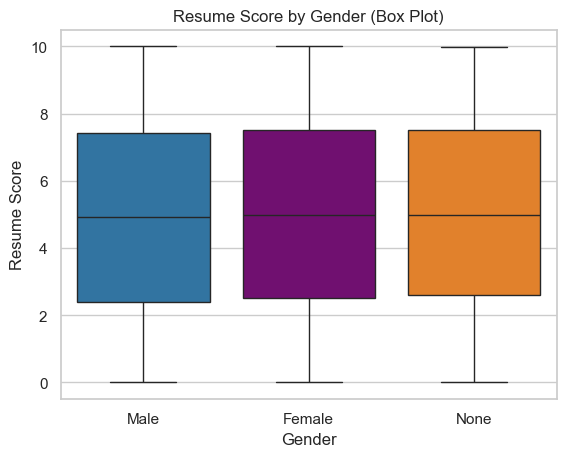

In [104]:
resume_scored_evaluated = pd.read_csv("/Users/ziaozhang/Desktop/CSCI1951Z_FinalProject/1_4000_resumes_evaluated.csv")
genders = ['M', 'F', None]
resume_male = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'] == 'M', 'Resume score']
resume_female = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'] == 'F', 'Resume score']
resume_n = resume_scored_evaluated.loc[resume_scored_evaluated['Gender'].isna(), 'Resume score']  # Filter NaN values

# Create a DataFrame
df = pd.DataFrame({
    'Gender': ['Male'] * len(resume_male) + ['Female'] * len(resume_female) + ['None'] * len(resume_n),
    'Resume Score': list(resume_male) + list(resume_female) + list(resume_n),
})

# Define custom colors
colors = ["#1f77b4", 'purple', "#ff7f0e"]

# Create a box plot
sns.boxplot(x='Gender', y='Resume Score', data=df, palette=colors)

plt.xlabel('Gender')
plt.ylabel('Resume Score')
plt.title('Resume Score by Gender (Box Plot)')
plt.show()

Selection Rates by Gender:
Gender
F      0.370206
M      0.620137
NaN    0.000000
Name: prediction, dtype: float64


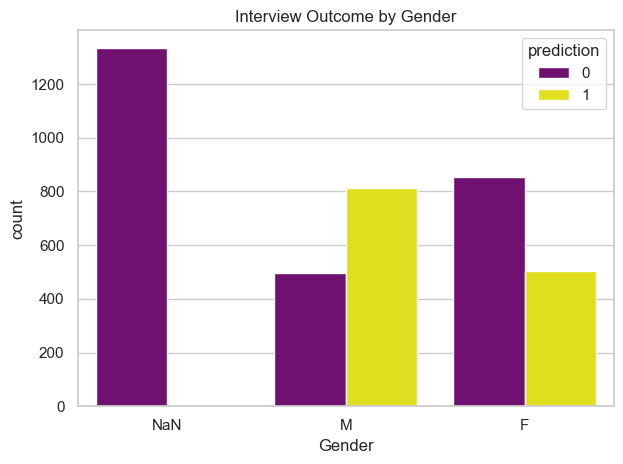

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
resume_scored_evaluated = pd.read_csv("/Users/ziaozhang/Desktop/CSCI1951Z_FinalProject/1_4000_resumes_evaluated.csv")
#resume_scored_evaluated = pd.read_csv("/Users/ziaozhang/Desktop/CSCI1951Z_FinalProject/2_4000_resumes_evaluated.csv")
# 1. Selection rates for interviews by Gender
resume_scored_evaluated['Gender'] = resume_scored_evaluated['Gender'].fillna('NaN')

# Calculate selection rates by gender
selection_rate_gender = resume_scored_evaluated.groupby('Gender')['prediction'].mean()

print("Selection Rates by Gender:")
print(selection_rate_gender)

# 2. Graphs: distribution of resume scores and predictions by gender

colors=["purple", "yellow"]
# Bar Plot of Interview Outcomes by Gender
sns.countplot(data=resume_scored_evaluated, x='Gender', hue='prediction', palette=colors)
ax[1].set_title('Interview Outcomes by Gender')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Count')
plt.title('Interview Outcome by Gender')
plt.tight_layout()
plt.show()

In [18]:
# See the
gender_filtered = resume_scored_evaluated[resume_scored_evaluated['Gender'].isin(['M', 'F'])]
gender_filtered['Gender'] = gender_filtered['Gender'].astype('category')

formula = 'prediction ~ Q("Resume score") * C(Gender)'

model = smf.logit(formula=formula, data=gender_filtered).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.579649
         Iterations 5


/var/folders/8h/8m5283r1505dpq6ffd1vy0ym0000gn/T/ipykernel_71678/3357905432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_filtered['Gender'] = gender_filtered['Gender'].astype('category')


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             prediction   No. Observations:                 2667
Model:                          Logit   Df Residuals:                     2663
Method:                           MLE   Df Model:                            3
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.01483
Time:                        09:40:17   Log-Likelihood:                -1545.9
converged:                       True   LL-Null:                       -1569.2
Covariance Type:            nonrobust   LLR p-value:                 4.317e-10
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.3588      0.133    -10.244      0.000      -1.619      -1.099
C(Gender)[T.M]                       0.5678      0.177      3.216      0.001       0.222       0.914
Q("Resume score")                    0.0165      0.023      0.727      0.467      -0.028       0.061
Q("Resume score"):C(Gender)[T.M]     0.0039      0.030      0.127      0.899      -0.056       0.063
====================================================================================================
"""

## Evaluation in 3 Baisc Independence

In [115]:
# Data Splitting
df_clean = resume_scored_evaluated.dropna(subset=['Gender']).reset_index(drop=True)
y_hat_example = df_clean.iloc[:, -1].tolist()       # Outcome is corresponding ot Prediction 
group_test_example = df_clean['Gender'].tolist()


In [118]:
def independence(y_hat, group):
  """
  Computes an independence metric between two specific groups.

  Args:
    y_hat (np.ndarray): Classifier predictions.
    group (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: independence measure
  """
  # TODO: compute independence
  conditional_above=sum(1 for x, y in zip(y_hat, group) if x == 1 and y == 'F')/len([item for item in group if item == 'F'])
  conditional_below=sum(1 for x, y in zip(y_hat, group) if x == 0 and y == 'M')/len([item for item in group if item == 'M'])
  independence_metric=conditional_above/conditional_below
  return independence_metric


In [119]:
independence(y_hat_example,group_test_example)

0.32780869547587915

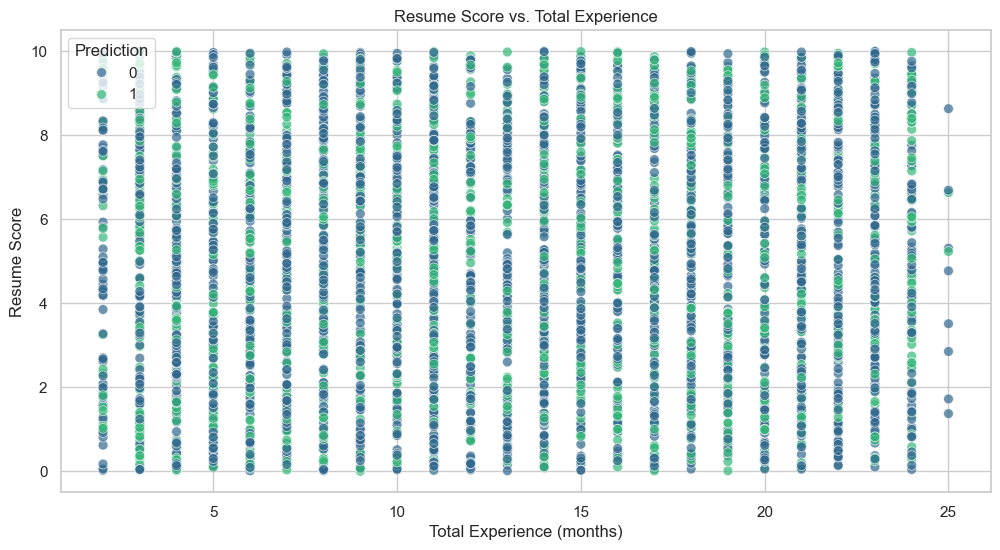

In [136]:
resume_scored_evaluated = pd.read_csv("/Users/ziaozhang/Desktop/CSCI1951Z_FinalProject/2_4000_resumes_evaluated.csv")
from datetime import datetime

def calculate_duration(start_date, end_date):
    start = datetime.strptime(start_date, "%m/%y")
    end = datetime.strptime(str(end_date), "%m/%y")
    duration = (end.year - start.year) * 12 + (end.month - start.month)
    return max(0, duration)  # to avoid negative durations due to data inconsistencies

resume_scored_evaluated ['Total Experience'] = (resume_scored_evaluated.apply(lambda x: calculate_duration(x['Start 1'], x['End 1']), axis=1))
plt.figure(figsize=(12, 6))
sns.scatterplot(x=resume_scored_evaluated ['Total Experience'], y=resume_scored_evaluated ['Resume score'], hue=resume_scored_evaluated['prediction'], palette='viridis', alpha=0.7, s=50)
plt.title('Resume Score vs. Total Experience')
plt.xlabel('Total Experience (months)')
plt.ylabel('Resume Score')
plt.grid(True)
plt.legend(title='Prediction', loc='upper left')

plt.show()



## Evidence from Statistical Test in Scorer Model

In [137]:
model_linear = smf.ols('Q("Resume score") ~ Gender', data=resume_scored_evaluated).fit()
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:      Q("Resume score")   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.005818
Date:                Wed, 08 May 2024   Prob (F-statistic):              0.939
Time:                        20:43:21   Log-Likelihood:                -6604.4
No. Observations:                2667   AIC:                         1.321e+04
Df Residuals:                    2665   BIC:                         1.322e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9199      0.078     62.907      